In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
from pathlib import Path

### Data exploration

In [2]:
data = []

for file in Path("data").glob("*.mat"):
    try:
        data.append(loadmat(file))
    except Exception as e:
        print(f"Error loading {file}: {e}")

data_1 = data[0]

In [3]:
data_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])

In [4]:
type(data_1)

dict

In [5]:
A = data_1['amplitudes1']
distance = data_1['distances1']
PC = data_1['cloud1']

In [6]:
distance

array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
        0.        ],
       ...,
       [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
        0.        ],
       [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.85190231,
        0.        ],
       [0.        , 0.92695111, 0.        , ..., 0.88022852, 0.84321123,
        0.        ]], shape=(424, 512))

In [7]:
print(A.shape, distance.shape, A.dtype, distance.dtype)
print(np.nanmin(distance), np.nanmax(distance))

(424, 512) (424, 512) uint16 float64
0.0 10.372331619262695


(np.float64(-0.5), np.float64(511.5), np.float64(423.5), np.float64(-0.5))

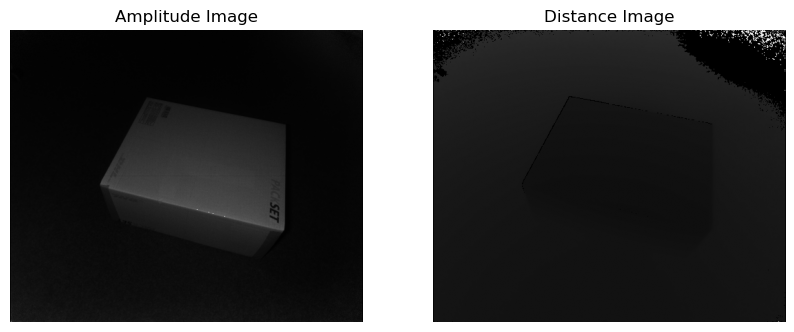

In [ ]:
# Visualize distance and amplitude image
fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(A, cmap='gray') 
ax[0].set_title('Amplitude Image') 
ax[0].axis('off') 
ax[1].imshow(distance, cmap='gray') 
ax[1].set_title('Distance Image') 
ax[1].axis('off')

The box is visible since its a solid surface and reflecting light well.

Distance image looks almost entirely the same color. Can't really understand the distance that well

In [9]:
print(f"Amplitude range: {A.min()} to {A.max()}")
print(f"Distance range: {distance.min()} to {distance.max()}")

Amplitude range: 0 to 65535
Distance range: 0.0 to 10.372331619262695


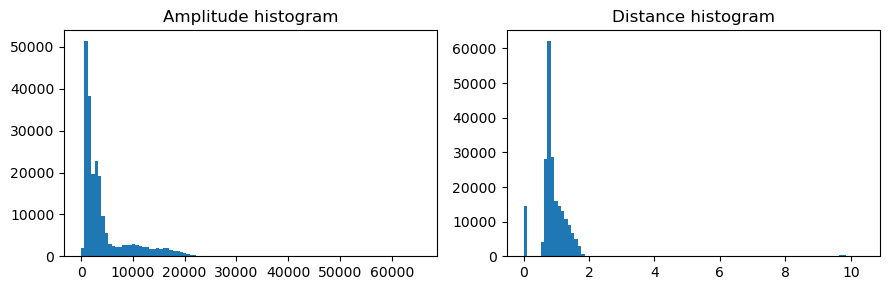

In [58]:
# checking where most pixels lie in distance image
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(A.ravel(), bins=100, range=(A.min(), A.max()))
plt.title("Amplitude histogram")


plt.subplot(1,2,2)
plt.hist(distance.ravel(), bins=100, range=(distance.min(), distance.max()))
plt.title("Distance histogram")
plt.tight_layout()
plt.show()

So most depth values are between .15 to 2. Values around zero are not included as the object can't be 0 m away. So it is probably a failed reading

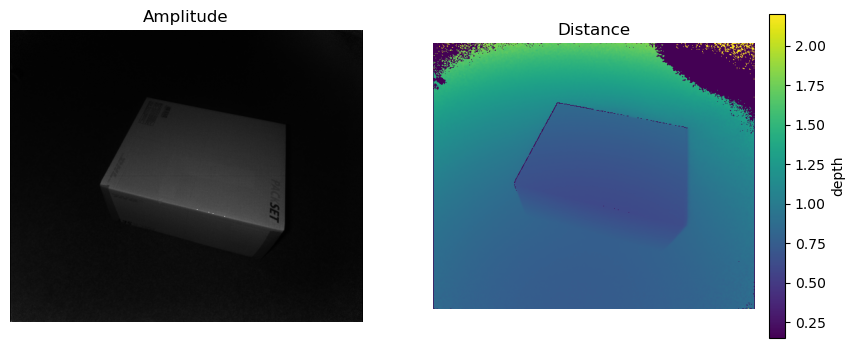

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Amplitude') 
ax[0].axis('off')

# visualizing distance with with defined vmin and vmax
im = ax[1].imshow(distance, cmap='viridis', vmin=0.15, vmax=2.2)
ax[1].set_title('Distance') 
ax[1].axis('off')
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label='depth')


Strong border along the edges which drops in distance. So this might actually be an artifact due to weak signals

### Point cloud plot

In [53]:
PC

array([[[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.13569915, -0.88586158,  1.51099968],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.20425951, -0.9299584 ,  1.60499978],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       ...,

       [[-0.        ,  0.        ,  0.        ],
        [-0

In [59]:
# extract pixel value at each space
X = PC[:,:, 0].ravel()
Y = PC[:,:, 1].ravel()
Z = PC[:,:, 2].ravel()

X.shape, Y.shape, Z.shape

((217088,), (217088,), (217088,))

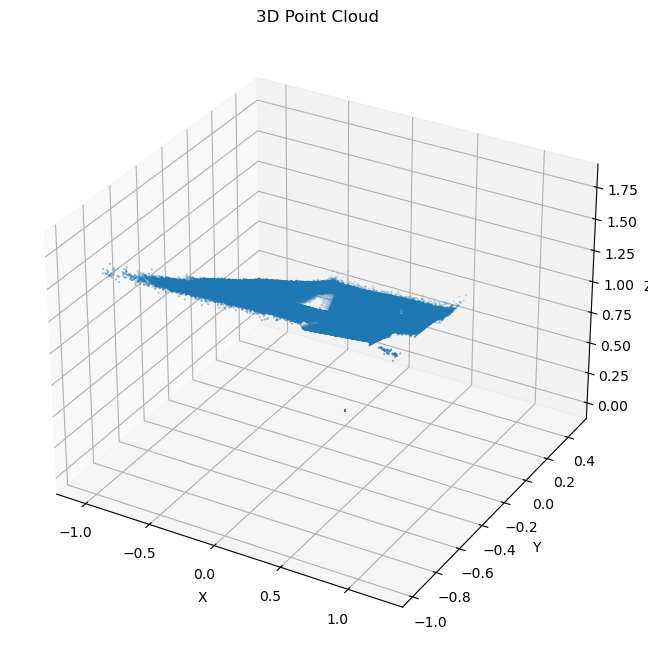

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, s=0.1)

ax.set_title('3D Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


The current point cloud contains a lot of redundant points (background, outliers) which we can clean up with thresholding the amplitude and distance as we are only interested in the point cloud for the box.

### Filtering to remove noise

We want sharper edges and less speckle noise. So first we test out mean and median filters to see how they effect the A and distance images

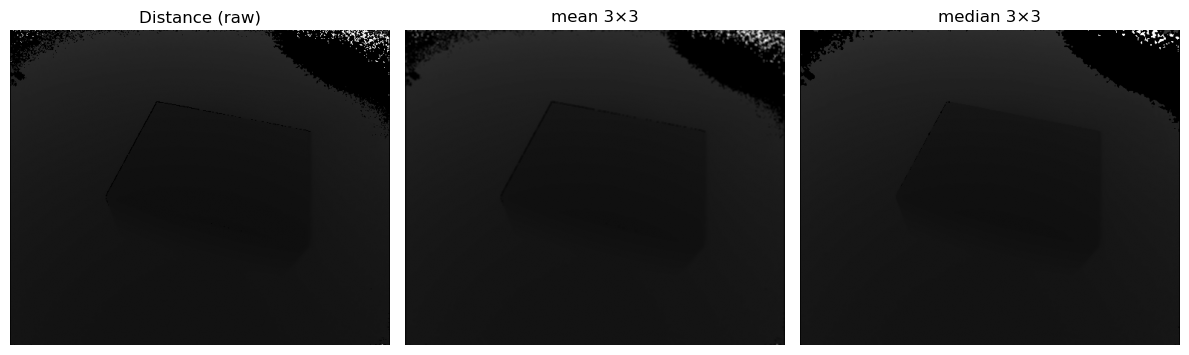

In [ ]:
# testing mean and median filters on distance image

from scipy.ndimage import median_filter, uniform_filter

D_mean3 = uniform_filter(distance, size=3)
D_mean5 = uniform_filter(distance, size=5)
D_median3 = median_filter(distance, size=3)   

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(distance, cmap='grey')
ax[0].set_title("Distance (raw)")
ax[0].axis('off')

ax[1].imshow(D_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(D_median3, cmap='grey')
ax[2].set_title("median 3×3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

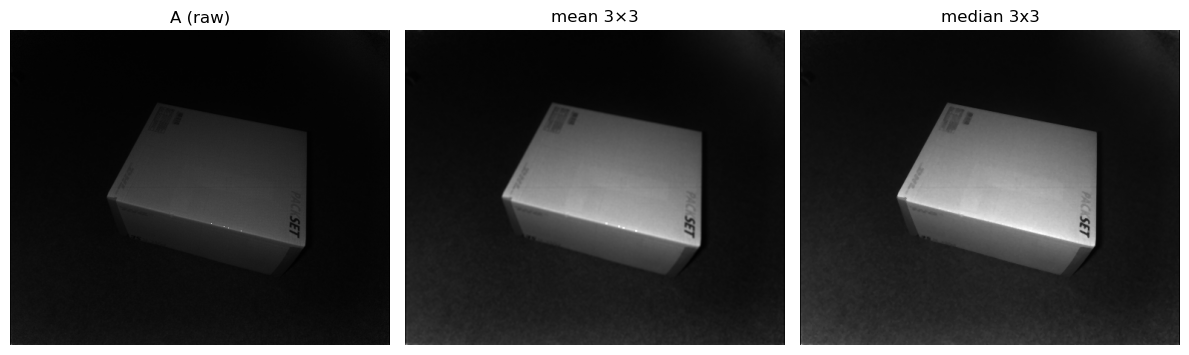

In [62]:
# testing mean and median filters on amplitude image
A_mean3 = uniform_filter(A, size=3)
A_med3 = median_filter(A, size=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(A, cmap='grey')
ax[0].set_title("A (raw)")   
ax[0].axis('off')

ax[1].imshow(A_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(A_med3, cmap='grey')
ax[2].set_title("median 3x3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Data clean up (Invalid/weak signals, extreme distance)

We want to keep the pixels that are 
- have some signal returned
- within a sensible distance

Lots of low amplitudes meaning that the signals here are not reliable. 

We can also ignore the 0 values in the distance data as it suggests missing data 

### Remove nan and negative data

In [109]:
# A_new = A_mean5.astype(float)  

invalid = (
    ~np.isfinite(PC).all(axis=-1) | # remove NaN in any of the X,Y,Z coords 
    (PC[:, :, 2] == 0) |            #  
    ~np.isfinite(D_median3) |    # remove NaN in distance
    (D_median3 <= 0) |           # remove zero or negative distances
    (A_med3 <= 0)                   # remove zero or negative amplitudes
)
valid_mask = ~invalid     # pixels to keep

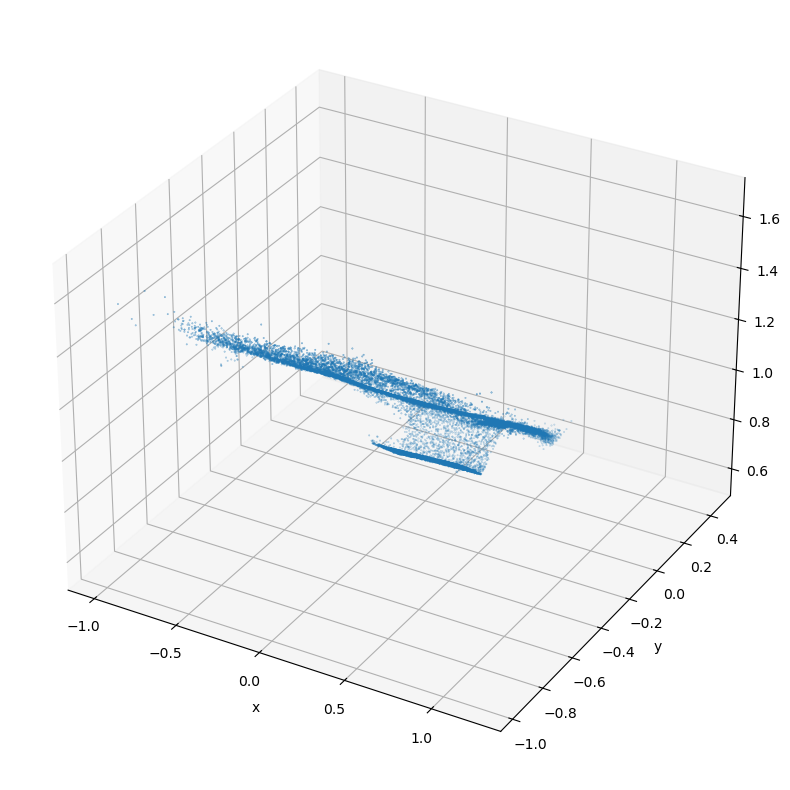

In [121]:
rows, cols = np.where(valid_mask)
if rows.size == 0:
    print("No points to plot after filtering.")
else:
    # downsample for speed
    sel = np.random.choice(rows.size, min(20_000, rows.size), replace=False)
    rows, cols = rows[sel], cols[sel]

    X = PC[rows, cols, 0]
    Y = PC[rows, cols, 1]
    Z = PC[rows, cols, 2]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X, Y, Z, s=0.1)              

    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

    plt.tight_layout(); plt.show()


### RANSAC

In [ ]:
def apply_mask(PC, mask):
    """Applies a defined mask to the point cloud."""
    rows, cols = np.where(mask)
    PC_masked = PC[rows, cols, :].astype(float)
    return PC_masked, rows, cols

def fit_plane(points):
    """ 
    Takes 3 points (3x3 array) and fits a plane. Returns 
    unit normal n and offset d.
    """
    p1, p2, p3 = points
    # form edge vectors
    vec1 = p2 - p1
    vec2 = p3 - p1

    n_raw = np.cross(vec1, vec2)
    normal_len = np.linalg.norm(n_raw)

    # if collinear points, return None
    if normal_len == 0:
        return None, None, False
    n = n_raw / normal_len
    d = -float(np.dot(n, p1))
    
    return n, d, True

def calculate_distance(points, n, d):
    """Finds the point to plane distances for multiple points (N,3) at once."""
    values = np.abs(np.dot(points, n) + d)
    return values

def find_inliers(distances, threshold):
    inliers_mask = distances < threshold
    inliers_idx = np.nonzero(inliers_mask)[0]
    inliers_count = inliers_mask.sum()

    return inliers_mask, inliers_idx, int(inliers_count)

def sample_points(p):
    return np.random.choice(p, 3, replace=False)


In [116]:
def RANSAC(PC, max_iter, distance_thresh):
    best_count = -1
    best_n = None
    best_d = None
    best_inliers = None

    if PC.shape[0] < 3:
        raise ValueError("Not enough points to fit a plane.")
    
    for iter in range(max_iter):
        points = sample_points(PC.shape[0])
        n, d, valid = fit_plane(PC[points, :])

        if not valid:
            continue

        distances = calculate_distance(PC, n, d)
        inliers, idx, inlier_count = find_inliers(distances, distance_thresh)

        if inlier_count > best_count:
            best_count = inlier_count
            best_n = n
            best_d = d
            best_inliers = inliers
        
    return best_n, best_d, best_inliers, best_count
    

In [ ]:
P_all, rows, cols = apply_mask(PC, valid_mask)   # P_all is (N,3)
best_n, best_d, best_mask1d, best_cnt = RANSAC(P_all, max_iter=5000, distance_thresh=0.05)
print("best inliers:", best_cnt, "of", P_all.shape[0])

best inliers: 155789 of 201541


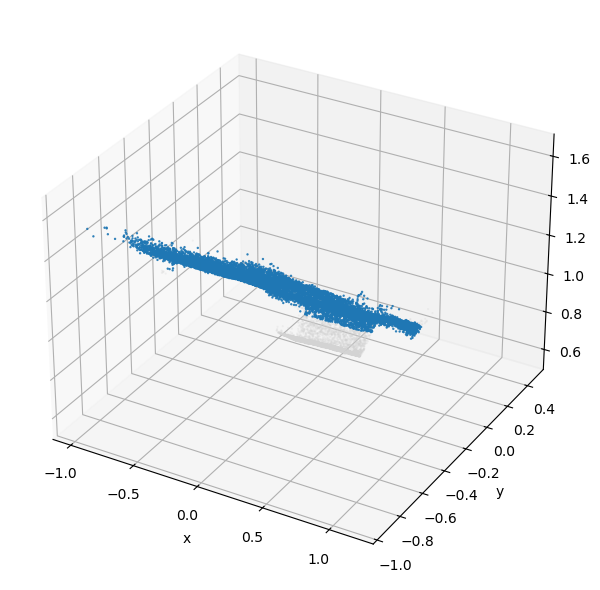

In [118]:
N = P_all.shape[0]
sub = np.random.choice(N, min(30_000, N), replace=False)
inl_sub = best_mask1d[sub]
X, Y, Z = P_all[sub,0], P_all[sub,1], P_all[sub,2]

fig = plt.figure(figsize=(7,6)); ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[~inl_sub], Y[~inl_sub], Z[~inl_sub], s=0.25, c='lightgray', alpha=0.25)
ax.scatter(X[inl_sub],  Y[inl_sub],  Z[inl_sub],  s=0.5,  c='tab:blue', alpha=0.9)

ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout(); plt.show()

### Map and visualize the inliers in the image

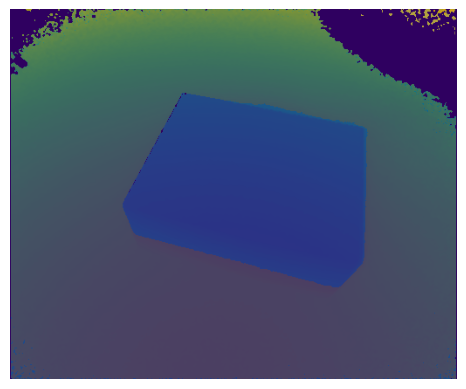

Floor inliers (pixels): 155939 out of 217088


In [ ]:
# best_mask1d came from RANSAC on P_all, with rows, cols from apply_mask(PC, keep2)
H, W = PC.shape[:2]
floor_mask = np.zeros((H, W), dtype=bool)
floor_mask[rows[best_mask1d], cols[best_mask1d]] = True
# overlay on your filtered distance image
plt.imshow(D_median3, cmap='viridis', vmin=0.15, vmax=2.2)
plt.imshow(floor_mask, cmap='jet', alpha=0.3)
plt.axis('off')
plt.show()
print("Floor inliers (pixels):", floor_mask.sum(), "out of", H*W)



### Morphological operators on masked image

Floor inliers (pixels): 154920 out of 217088


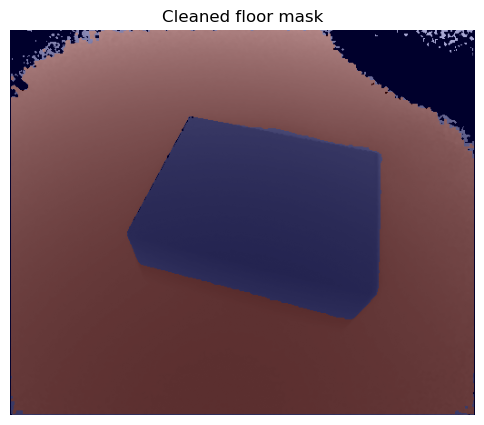

In [98]:
from scipy.ndimage import binary_opening, binary_closing


kernel = np.ones((3,3), dtype=bool)
floor_mask_clean = binary_opening(floor_mask, structure=kernel)
floor_mask_clean = binary_closing(floor_mask_clean, structure=kernel)
print("Floor inliers (pixels):", floor_mask_clean.sum(), "out of", H*W)
plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray', vmin=0.15, vmax=2.2)
plt.imshow(floor_mask_clean, cmap='jet', alpha=0.35)
plt.title("Cleaned floor mask")
plt.axis('off')
plt.show()


### Remove the floor inliers and visualize the rest

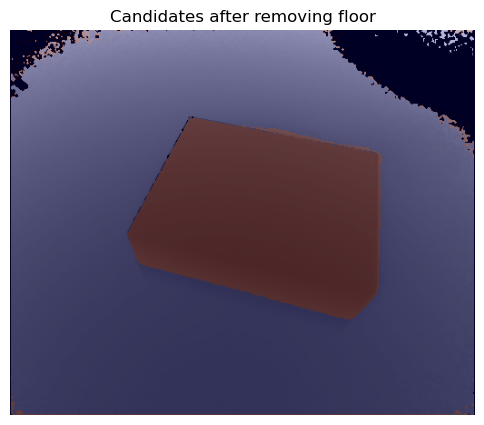

In [99]:
valid0 = np.isfinite(PC).all(axis=2) & (PC[...,2] != 0)
keep_nonfloor = valid0 & ~floor_mask_clean

# Convert back to point list for RANSAC #2
P2, ii2, jj2 = apply_mask(PC, keep_nonfloor)

plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray', vmin=0.15, vmax=2.2)
plt.imshow(keep_nonfloor, cmap='jet', alpha=0.30)
plt.title("Candidates after removing floor"); plt.axis('off')
plt.show()


### Finding the top plane of the box

Top-plane inliers: 36346 of 47305


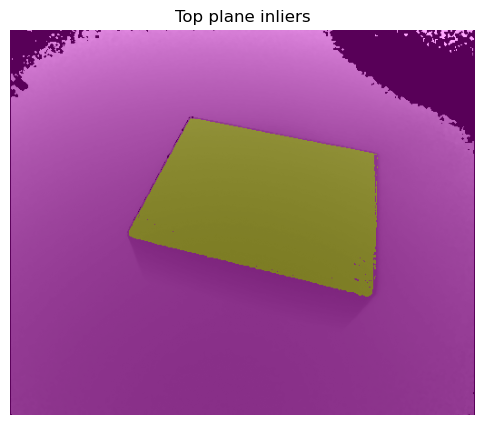

In [100]:
thresh = 0.007  # start with your floor tau
n_top, d_top, inl2_1d, cnt2 = RANSAC(P2, max_iter=2000, distance_thresh=thresh)
print("Top-plane inliers:", cnt2, "of", P2.shape[0])

# map top inliers to an image mask
top_mask = np.zeros(valid0.shape, dtype=bool)
top_mask[ii2[inl2_1d], jj2[inl2_1d]] = True

plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray', vmin=0.15, vmax=2.2)
plt.imshow(top_mask, cmap='spring', alpha=0.35)
plt.title("Top plane inliers"); plt.axis('off'); plt.show()


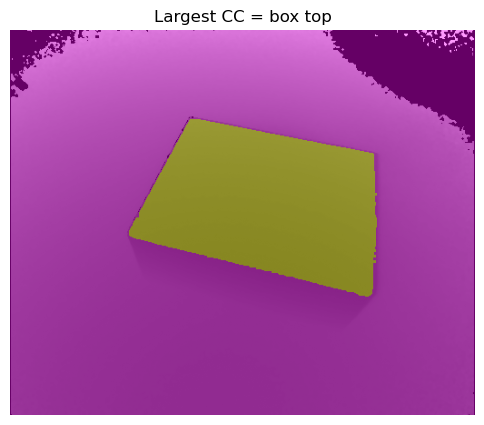

In [101]:
from scipy.ndimage import label, binary_opening, binary_closing

lbl, num = label(top_mask)              # 4-connected
sizes = np.bincount(lbl.ravel()); sizes[0] = 0
box_top_mask = (lbl == sizes.argmax())  # largest CC

# optional tiny cleanup
ker = np.ones((3,3), bool)
box_top_mask = binary_opening(box_top_mask, ker)
box_top_mask = binary_closing(box_top_mask, ker)

plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray', vmin=0.15, vmax=2.2)
plt.imshow(box_top_mask, cmap='spring', alpha=0.40)
plt.title("Largest CC = box top"); plt.axis('off'); plt.show()


In [102]:
box_top_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(424, 512))

In [103]:
if np.dot(n_top, best_n) < 0:
    n_top, d_top = -n_top, -d_top

# perpendicular separation (meters)
height_m = abs(d_top - best_d)
print("Box height (m):", height_m)

Box height (m): 0.1574155940615266


In [104]:
# Calculating the length and width of the box
# C1 top left, C2 bottom right, C3 top right, C4 bottom left

rows, cols = np.where(box_top_mask)
C1_idx = np.argmin(rows + cols)
C1_2d = (rows[C1_idx], cols[C1_idx])
C1_3d = PC[C1_2d[0], C1_2d[1]]
C2_idx = np.argmax(rows + cols)
C2_2d = (rows[C2_idx], cols[C2_idx])
C2_3d = PC[C2_2d[0], C2_2d[1]]
C3_idx = np.argmin(rows - cols)
C3_2d = (rows[C3_idx], cols[C3_idx])
C3_3d = PC[C3_2d[0], C3_2d[1]]
C4_idx = np.argmax(rows - cols)
C4_2d = (rows[C4_idx], cols[C4_idx])
C4_3d = PC[C4_2d[0], C4_2d[1]]
length = np.linalg.norm(C1_3d-C3_3d)
width = np.linalg.norm(C1_3d-C4_3d)
print(f"length: {length}, width: {width}")

length: 0.44332316638878105, width: 0.3446152553488421


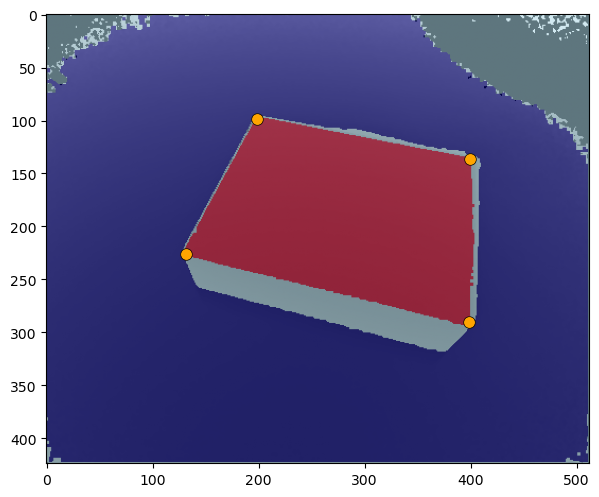

In [105]:
import matplotlib.colors as mcolors

corners_ij = np.array([C1_2d, C2_2d, C3_2d, C4_2d], dtype=int)

H, W = D_median3.shape
vis = np.zeros((H, W, 3), float)

vis[...] = mcolors.to_rgb('lightblue')
vis[floor_mask_clean] = mcolors.to_rgb('navy')  
vis[box_top_mask] = mcolors.to_rgb('crimson')

plt.figure(figsize=(7,6))
plt.imshow(D_median3, cmap='gray', vmin=0.15, vmax=2.2)
plt.imshow(vis, alpha=0.55)

# draw corners
xs, ys = corners_ij[:,1], corners_ij[:,0]
plt.scatter(xs, ys, s=70, c='orange', edgecolors='k', linewidths=0.5)



### Discussion